# The influence of promotions on the sales of a supermarket 

Authors : Jarod Vanderlynden , Philippe Mathieu, [CRISTAL Lab](http://www.cristal.univ-lille.fr), [SMAC team](https://www.cristal.univ-lille.fr/?rubrique27&eid=17), [Lille University](http://www.univ-lille.fr), Romain Warlop, [fifty-five](https://www.fifty-five.com/fr/)

email : jarod.vanderlynden.etu@univ-lille.fr

Created : 30/01/2023


***
## Introduction

This Jupyter notebook decribes how to use the model proposed in the article "_Understanding the impact of pricing strategies on consumer behavior_". This model allows to build a simulation tool that reproduces known marketing facts while measuring their impacts. This notebook is in 2 parts, the first part details the model and presents its functioning. The second part presents an example of use of the model.

## The model

This model represents a supermarket in which everyday consumer goods are sold. The agents are abstractions of the customers (a person, a family, etc.) each with their own internal parameters (sensitivities). The agents are omniscient and know all the products. The model does not take into account the geography of the store or the location of the products. 


In [1]:
from src.model import *
import seaborn as sns
sns.set_theme()

### The packs

Consumers good studied can be considered as packs, defined as a sum of a same entity. In order to cover all situations, all of the products which can be sold in the supermarket can be described as packs. A pack can be composed of a single product or the same product repeated several times. We do not deal in this model with packs of different products. 

Packs are sets of simple consumer goods, with 5 characteristics: a price, a quality, a quantity, and a promotion boolean. They are identified by their name. 

They are instantiated via the class `Pack(Name,Price,Quality,Quantity)`. The `price` is a unit price (for one product), the `quality` a real number between 0 and 1, 0 representing a poor quality and 1 representing the best possible quality. The `quantity` of product refers to the number of unit products in the pack. For simplicity, we do not model the volume of a product (in grams, ml, etc.). When a pack is initially created, the promotion is set to `False`, which is why it is not in the constructor function. The products themselves are not modeled and are defined through the packs. 


In [2]:
# un pack de 2 paquets de pâtes
p0 = Pack("Pasta of brand X", 2.3, 0.5, 2)

# une seule bouteille de shampoing de qualité
p1 = Pack("Shampoo of brand X", 18.0, 1.0, 1)

# un lot 4 shampoings de moyenne gamme
p2 = Pack("Shampoo of brand Y", 5.0, 0.5, 4)


The pack `p0` is a pack of 2 products, with a unit price of `2.3`, which gives a total price for the pack of 4.6.

In [3]:
p0.getPriceUnit(),p0.getTotalPrice()

(2.3, 4.6)

For the sake of realism, the packs are divided into different categories. A category represents packs of products which are comparable to each other. In this model a customer will choose only one pack in a given category (e.g. a pack of 6 bottles of water, in the category "waters").

A category is instantiated with `Category(name,list of packs)`. The creation of a category requires a list of packs. This list of packs can be initially empty, in which case we can add packs as we go along using the `add_pack(pack)` method. 

In [4]:
# Pasta
cat1 = Category("pasta",[p0])
cat1.showPacks()

Name :  Pasta of brand X , Total price :  4.6


0

In [5]:
# Shampoo
cat2 = Category("shampoing",[])
cat2.addPack(p1)
cat2.addPack(p2)
cat2.showPacks()

Name :  Shampoo of brand Y , Total price :  20.0
Name :  Shampoo of brand X , Total price :  18.0


0

- A pack gives access to several methods including ``getName(),getTotalPrice(),simplePromotion(percent)``, percent being the percentage discount to be applied to the product during a promotion.
- A category gives access to several methods including ``addPack(pack), getPacks(), showPacks()``

### The ABM environment

The environment corresponds to a supermarket. In this model, we are not interested in the geographical placement of the packs, and the agents are omniscient. It is therefore not necessary to explicitly represent the environment.
The agent-based model (ABM) is therefore only made of the agents and the list of studied packs. In order to instantiate it, we provide it with a list of categories which themselves contain the packs. 
A more complete store should ideally contain several categories with several packs. The model is capable of handling multiple categories simultaneously, but in this example we'll stick to a single category to illustrate our results.
The ABM is instantiated with `SMA(list_cat[cat1,cat2,...],nb_agent,nb_ticks)`, `list_cat` being a list of categories, `nb_agent` the number of agents, and `nb_ticks` the number of simulation time steps we wish to perform. A tick corresponds to the fact that all agents go to the supermarket 1 time (we could consider that it is 1 week).

In this simplified model, we assume that packs are available in infinite quantities. Therefore, there is no stock to manage and no out of stock situation. 

The parameter `nb_agents` generates `n` agents whose characteristics are random (needs, sensitivities etc ...).


In [6]:
# Ceate an ABM with 0 random agents.
myABM = SMA([cat1,cat2],0,10)

In [7]:
myABM.initialize()

0

There are no agents yet. If the simulation is launched now, of course nothing happens.
The methods `getTurnover()` allows us to obtain the turnover of the store at each time step of the simulation.
We have previously indicated our wish to have 10 rounds of speech for each agents, if we run the ABM, we obtain 10 values, all of them at zero for the moment since there is nobody.

In [8]:
myABM.run()
myABM.getTurnover()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### The agents

Agents represent clients. A customer has his own characteristics (sensitivities) and makes choices accordingly during his buying process. 
It is instantiated via the class `Agent(name, ABM, hLength, History, Profile)`. ABM refers to the system in which the agent evolves. `History, hLength, profile` are optional parameters (random if not specified and hLength is 50). `hLength` represents the maximum size of the agent's history in a sliding window (the last n purchases). 

In [9]:
# This agent has a randomly drawn purchase history and profile. 
a1 = Agent("agent 1",myABM,hLength = 20)

#### The profiles / Sensitivities
In order to have a behavioral differentiation between the agents, each one is endowed with a specific profile. In this model, the profile of an agent is detemined by its sensitivities: It consists of a map of 4 keys `Price`, `Quality`, `Inertial` `Promophile`, associated with percentage values totaling 100%. Some agents give more importance to the price, they correspond to customers with small budget. On the other hand, some agents give a lot of importance to quality, they correspond to customers with a big budget, buying good quality products. The promophiles are sensitive to promotions, the inertials are brand loyal. When all these variables are roughly equivalent, we speak of a balanced profile. In this case, the customers give a similar importance to all the characteristics of the products. 

In [10]:
# Creation of a promotion and price sensitive profile
profile1 = Profil({'inertia': 0.03,'price': 0.46,'quality': 0.05,'promophile': 0.46})
profile1.getProfil()

{'inertia': 0.03, 'price': 0.46, 'quality': 0.05, 'promophile': 0.46}

In [11]:
# Creation of a quality sensitive and loyal profile
profile2 = Profil({'price': 1,'quality': 20,'inertia': 20,'promophile': 1})
profile2.getProfil()

{'inertia': 0.47619047619047616,
 'price': 0.023809523809523808,
 'quality': 0.47619047619047616,
 'promophile': 0.023809523809523808}

The sum of the sensitivities is always 1 (100%).

The profile can be assigned to an agent at its creation. 

In [12]:
a2 = Agent("Agent 2", myABM, profil=profile1)
print(a2.name, ':' , a2.getProfil())

a3 = Agent("Agent 3", myABM, profil=profile2)
print(a3.name , ':' , a3.getProfil() )

Agent 2 : {'inertia': 0.03, 'price': 0.46, 'quality': 0.05, 'promophile': 0.46}
Agent 3 : {'inertia': 0.47619047619047616, 'price': 0.023809523809523808, 'quality': 0.47619047619047616, 'promophile': 0.023809523809523808}


It is also possible to create an agent with a random profile. In this case, the draw is can be uniform (balanced profile) or not and randomly defines a profile that is either balanced or that emphasizes one of the 4 characteristics.

In [13]:
# initialisation d'un profil aléatoire
a4 = Agent("Agent 4",myABM)
a4.getProfil()

{'inertia': array([0.07880264]),
 'price': array([0.04927191]),
 'quality': array([0.80428823]),
 'promophile': array([0.06763722])}

### History

The history represents the last purchases of an agent for each category. This history is a map with as keys the category names and as values the list of packs bought by this agent (with the quantity of packs bought). 

In [14]:
# The randomly generated history of one agent we have created. 
a1.getHistory()

{'pasta': [(Pasta of brand X, 3),
  (Pasta of brand X, 5),
  (Pasta of brand X, 6),
  (Pasta of brand X, 2),
  (Pasta of brand X, 2),
  (Pasta of brand X, 2),
  (Pasta of brand X, 2),
  (Pasta of brand X, 6),
  (Pasta of brand X, 4),
  (Pasta of brand X, 3),
  (Pasta of brand X, 6),
  (Pasta of brand X, 5),
  (Pasta of brand X, 5),
  (Pasta of brand X, 5),
  (Pasta of brand X, 5),
  (Pasta of brand X, 6),
  (Pasta of brand X, 2),
  (Pasta of brand X, 3),
  (Pasta of brand X, 7),
  (Pasta of brand X, 3)],
 'shampoing': [(Shampoo of brand Y, 4),
  (Shampoo of brand Y, 4),
  (Shampoo of brand X, 7),
  (Shampoo of brand X, 5),
  (Shampoo of brand X, 3),
  (Shampoo of brand X, 3),
  (Shampoo of brand X, 4),
  (Shampoo of brand Y, 6),
  (Shampoo of brand X, 6),
  (Shampoo of brand Y, 7),
  (Shampoo of brand Y, 3),
  (Shampoo of brand Y, 3),
  (Shampoo of brand X, 4),
  (Shampoo of brand X, 4),
  (Shampoo of brand X, 3),
  (Shampoo of brand X, 7),
  (Shampoo of brand Y, 5),
  (Shampoo of bran

To create a history there are 2 ways to do it: either pass through a `genHistory(cat_list, avg, length)` method or directly pass the list to an agent `History (dict{category1:purchases,...},dict{category1:quantity,....})`. The first method generates a history from the list of categories and the associated average. The second method requires a complete history. If the length doesn't match an error is returned

In [15]:
H = genHistory([cat1,cat2],[10,5],50)

In [16]:
a5 = Agent("Agent 5",myABM,history = H)
a5.getHistory()

{'pasta': [(Pasta of brand X, 13),
  (Pasta of brand X, 12),
  (Pasta of brand X, 13),
  (Pasta of brand X, 12),
  (Pasta of brand X, 10),
  (Pasta of brand X, 11),
  (Pasta of brand X, 13),
  (Pasta of brand X, 9),
  (Pasta of brand X, 9),
  (Pasta of brand X, 8),
  (Pasta of brand X, 7),
  (Pasta of brand X, 13),
  (Pasta of brand X, 9),
  (Pasta of brand X, 9),
  (Pasta of brand X, 11),
  (Pasta of brand X, 9),
  (Pasta of brand X, 12),
  (Pasta of brand X, 8),
  (Pasta of brand X, 9),
  (Pasta of brand X, 13),
  (Pasta of brand X, 11),
  (Pasta of brand X, 10),
  (Pasta of brand X, 8),
  (Pasta of brand X, 7),
  (Pasta of brand X, 8),
  (Pasta of brand X, 7),
  (Pasta of brand X, 13),
  (Pasta of brand X, 8),
  (Pasta of brand X, 7),
  (Pasta of brand X, 7),
  (Pasta of brand X, 11),
  (Pasta of brand X, 10),
  (Pasta of brand X, 11),
  (Pasta of brand X, 10),
  (Pasta of brand X, 12),
  (Pasta of brand X, 12),
  (Pasta of brand X, 10),
  (Pasta of brand X, 13),
  (Pasta of brand X

Let's add these 5 agents to our environment, taking care to pass a list as a parameter.

In [17]:
myABM.addAgent([a1,a2,a3,a4,a5])

### The simulation

We can now run a simulation. The simulation can be run several times, a different result will appear because of the stochastic aspect of the model, especially in the choice of agents. To make choices, the agent assigns a score to each pack according to its internal parameters and chooses a pack according to a probability law proportional to the score of the pack (relative to the scores of the other packs of the category). Agents can only choose one pack for each category but buy it in any quantity. (e.g. An aent choose the pack of 6 bottles of water, in the category "waters", and buy it 3 times). 

In [18]:
myABM.initialize()
myABM.run()
myABM.getTurnover()

array([410.2, 370. , 425.8, 320.8, 279.2, 638.2, 342.8, 578.8, 295.6,
        81.4])

The displayed list shows the evolution of the turnover at each time step for all the agents $Sum_{p \in P}(prix_P * quantité acheté_P)$, $P$ the set of purchases.

To better understand the mechanisms of this model, it is possible to display a trace of what the agents have bought.
Here we have recorded 5 agents who buy in 2 categories (so 2 different packs).

In [19]:
myABM.initialize()
myABM.run(trace=True)

Ticks num :  0 , Agent :  agent 1 , Need 4.15 , Bought :  Pasta of brand X , Number of pack bought :  1 , Total of units :  2  
Ticks num :  0 , Agent :  agent 1 , Need 4.35 , Bought :  Shampoo of brand X , Number of pack bought :  7 , Total of units :  7  
Ticks num :  0 , Agent :  Agent 2 , Need 8.94 , Bought :  Pasta of brand X , Number of pack bought :  9 , Total of units :  18  
Ticks num :  0 , Agent :  Agent 2 , Need 4.88 , Bought :  Shampoo of brand Y , Number of pack bought :  1 , Total of units :  4  
Ticks num :  0 , Agent :  Agent 3 , Need 6.7 , Bought :  Pasta of brand X , Number of pack bought :  3 , Total of units :  6  
Ticks num :  0 , Agent :  Agent 3 , Need 7.82 , Bought :  Shampoo of brand Y , Number of pack bought :  3 , Total of units :  12  
ticks num :  0 , Agent :  Agent 4 , Need :  5.32 , Bought : None , Quantity : 0
ticks num :  0 , Agent :  Agent 4 , Need :  3.62 , Bought : None , Quantity : 0
Ticks num :  0 , Agent :  Agent 5 , Need 9.94 , Bought :  Pasta o

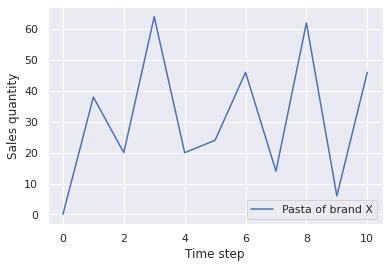

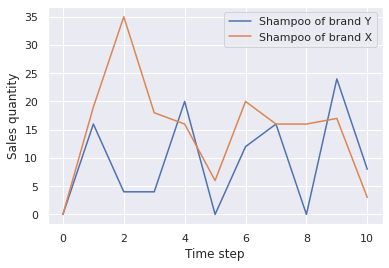

0

In [20]:
# Pour afficher les ventes de chaque packs
# Il trace automatiquement autant de graphiques qu'il y a de catégories
myABM.showPacksSales()

The `initialize` method is used to restart a simulation. A reset of the ABM does not change the history of the agents. It only resets the ABM settings (what has already been purchased).

After `initialize` the agents continue the new experiment with the profiles and purchase histories of the previous simulation. 

***
## Using the model for promotions

### The promotion
Now that we have our differentiated agents, each with their own profile (including promophiles) it is possible to study the influence of different promotions. The application of a promotion is done by the method `makePromo(type,quantity,ticks,category,pack)`.

`type`  is the type of promotion. (0 for percentage discount, 1 for x bought y offered)

`quantity` is the percentage of the promotion (if it's a % promotion) or a doublet (x,y) if it's a x bought y offered promotion.

`ticks` a doublet containing 2 integers, the strating time step of the promotion and the ending time step of the promotion. 

`category` The name of the category on which you want to run a promotion.

`pack` The name of the pack on which we want to make a promotion.

Let's make a larger simulation and a promotion. 

In [47]:
# Let's go back to a complete model

# The packs
base_price = np.random.randint(10, 100)
packs = []
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   # On tire un prix de base aléatoire
    quality = np.random.normal((price/100),0.1)               # On tire une qualité proportionelle au prix
    for i in range(2):                                        # Création de 3 produits qu'on considerera d'une même marque (même qualité)
        packs.append(Pack(("pack" + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9                                   # On estime que le prix à l'unité est plus bas sur les produits vendu en grande quantité

# The category
My_category = Category("myCategory", packs)

# We make 100 simulation time steps and we tell the ABM to create randomly 300 agents (with profiles equally distributed on the 5 possible ones).
testABM = SMA([My_category],300,100) 

In [22]:
# Here we launch the SMA on 100 time steps, with a promotion between time step 30 and 34

testABM.initialize()
testABM.makePromo(0,40,(30,34),"myCategory","pack0")
testABM.run()

#### Les différents affichages possible suite à une simulation

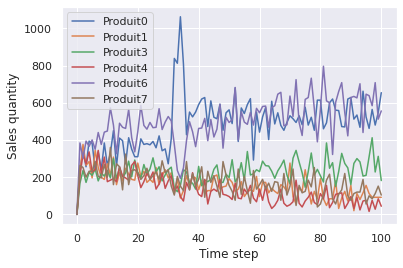

0

In [23]:
# Display of sales by product
# We see the peak of sales on product 0 between time step 30 and 34.
testABM.showPacksSales()

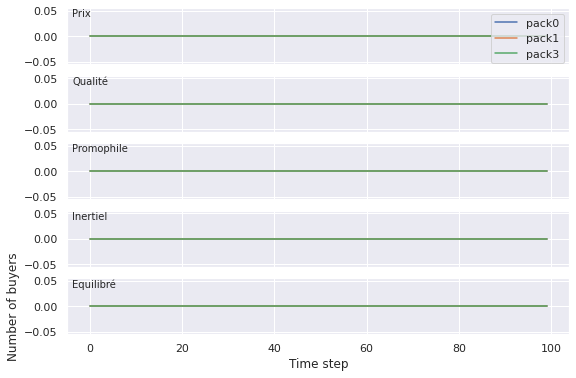

In [48]:
# Display of the number of buyers of the first 3 products according to their profile
# We always notice around time step 30 a peak of pack0 buyers from price agents and promophiles due to the promotion
testABM.showProfileSales()

Each agent has for each category a reference product (a quantity 1 pack). This reference product is a pack with specific characteristics determined by the agent's history. This reference is therefore updated at each time step in the simulation. This reference product corresponds to a mental reference of what seems to be a good product for the agent.

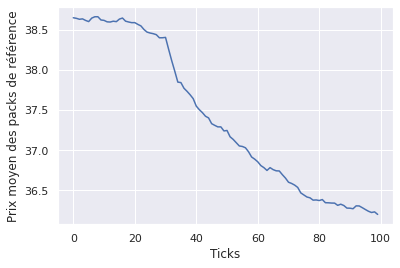

In [25]:
# Display of the average reference price (Average over all agents of the price's reference products of this category)
testABM.showMeanNeeds() 

On this graph, during a discount, the average reference price of the agents decreases, indeed the agents buy cheaper products because of the discount and the reference price is calculated according to what the agents buy.


We notice that some packs are more sold than others, especially the small quantity packs. Indeed, even if they are more expensive in unit price, they correspond to the needs of a larger number of agents. 

#### Conclusion

We observe on this simulation that pack0, which is the pack in promotion, sees a strong increase of its sales during the promotion, provokes a fall of the average reference price of the agents and according to the profiles of agents causes the development of loyalty. 

A second part where the experiments highlighted in the article _Understanding the impact of pricing strategies on consumer behavior_ are performed is available on the git page on the jupyter sheet _ENG\_Experiments_.
